In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit

## Building Machines

Beginning to build non-linear statistical prediction machines. Simple in nature, complicated in interactions.

## UC Berkely Admissions 

4526 graduate school applications for 1973 UC Berkely

Stratified by department and gender of applicant

Gender discrimination by admission officers?

**Mediation Analysis**

Causal foundations of bias, disparity and fairness - V.A.Traag, L. Waltman 2022

Rare outline of explicit causal framework, some dags, actual estimand

## Modelling events

Events: Discrete, unordered outcomes

Observations are counts

Unknowns are probabilities, odds

Everything interacts always everywhere

A beast known as "log-odds"

Will be mainly modelling on the logarithmmic scale

## Admissions

Was there gender discrimination in graduate admissions?
(gender) G->A (admission)

department(D) -> G
D             -> A

Some departments receive lot of applicants, some much less. 

What can the "causal effect of gender" mean?

Not the applicants gender that matters, but their perceived gender by the referee (who influences acceptance)

## Context & discrimination

x -> y ("direct discrimination)
x -> z -> y ("indirect discrimination, structural")

total discrimination is the sum of both types (its what people experience!)

each type requires a different estimator 


Which path is "discrimination"? 

Often the thing we want is not what we're able to estimate. 

Will deal with unobserved confounds later 

In [2]:
# Generative model, basic mediator scenario
#No Discrimination

N = 1000 # Number of applicants
# Even Gender distribution 
G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
accept_rate = np.array([[0.1,0.1],[0.3,0.3]])
# Simulate acceptance
A = np.random.binomial(1,accept_rate[D,G])

GD = np.histogram2d(G, D, bins=(2,2))[0]
GA = np.histogram2d(G, A, bins=(2,2))[0]

print('GD')
print(GD)
print('GA')
print(GA)
print('Acceptance Rates')
print('Gender 0: '+ str(GA[0,1]/np.sum(GA[0])))
print('Gender 1: '+ str(GA[1,1]/np.sum(GA[1])))

GD
[[354. 149.]
 [103. 394.]]
GA
[[416.  87.]
 [373. 124.]]
Acceptance Rates
Gender 0: 0.17296222664015903
Gender 1: 0.24949698189134809


In [3]:
# Generative model, basic mediator scenario
#Some Direct discrimination

N = 1000 # Number of applicants
# Even Gender distribution 
G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
accept_rate = np.array([[0.05,0.1],[0.2,0.3]])# Direct discrimation
# Simulate acceptance
A = np.random.binomial(1,accept_rate[D,G])

GD = np.histogram2d(G, D, bins=(2,2))[0]
GA = np.histogram2d(G, A, bins=(2,2))[0]

print('GD')
print(GD)
print('GA')
print(GA)
print('Acceptance Rates')
print('Gender 0: '+ str(GA[0,1]/np.sum(GA[0])))
print('Gender 1: '+ str(GA[1,1]/np.sum(GA[1])))

#Overall pattern is the same as the absence of discrimination!!!!

GD
[[334. 146.]
 [122. 398.]]
GA
[[446.  34.]
 [406. 114.]]
Acceptance Rates
Gender 0: 0.07083333333333333
Gender 1: 0.21923076923076923


## Generative model

Could do a lot better

Admission rate depends upon size of applicant pool, distribution of qualifications

Should sample applicant pool and then sort to select admissions

Rates are conditional on structure of applicant pool

## Modeling events

**We Observe**: Counts of events

**We estimate**: Probability (or log-odds) of events

Like the globe tossing model. but need "proportion of water" stratified by other variables.




## Generalized Linear Models

**Linear Models**: Expected value is additive ("linear")combination of parameters

e.g.

$Y \sim Normal (\mu,\sigma)$

$\mu = a + BxX + BzZ$

You can't do this with any distribution except the normal. The normal is unbounded

Other variables are bounded. Such as events which are counts.

**Generalized Linear Models**: Expected value is some function of an additive combination of parameters.

e.g. 

$Y \sim  Bernoulli(p)$ For each i, Y is a 0/1 outcome

$f(p) = a + Bx + BzZ$

$f()$ is the link function

$f^{-1}()$ is the inverse link function

Links parameters of distribution to linear model
f ^-1 is the inverse link function

E.g.

$f(a) = a^2$

$f^{-1}(a^2) = \sqrt(a^2) = a $


## Distributions and link functions

Distributions: Relative number of ways to observe data given assumptiosn about rates probabilities, slopes, etc.

Distributions are matched to contraints on observed variables

Link functions are matched to distributions

## Exponential Family

Distribution of the time to an event that has a constant rate in time. Positive real values. Has 1 parameter Lambda which is the rate 

If you have some process that is producing events in continuous time and you count them, you get a Binomial distribution.

**Poisson** is a special case of binomial where you don't know the maximum. Has the same lambda 

**Gamma** sum of exponential processes (lambda, k)

**Normal** For large means you become absorbed by the Normal! (mean, variance)

Think about the mapping. 

Distributional assumptions are assumptions about constraints on observations

You cannot "test" if you data are "normal"

## Distributions and link functions

Distributions: Relative number of ways to observe data given assumptions

Distributions are matched to contstraints on observed variables

Link functions are matched to distributions

## Logit Link

Bernoulli/Binomial models most often use **logit** link

$logit(p_i) = log({p}/{(1-p)})$ #Log dds
 
$Yi \sim Bernoulli(p)$

$logit(p) = a +BxX + BzZ$ Logistic

## Logit link is hars transform

"log-odds scale": The value of the linear model 

logit(p)=0,p=0.5

logit(p)=4,p=nearly always

logit(p)=-4,p=hardly ever


## Logistic priors

logit(pi) = a

The logit link compresses parameter distributions

Anything above +4 = almost always

Anything below -4 = almost never 

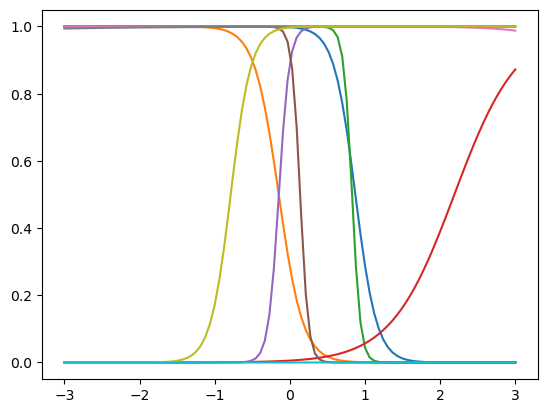

In [4]:
a = np.random.normal(0,10, size=1000)
b = np.random.normal(0,10, size=1000)
xseq = np.linspace(-3,3,num=100)
plist = []

for x in xseq:
    p = expit(a+b*x)
    plist.append(p[:10])
plist = np.array(plist)

for i in range(10): 
    plt.plot(xseq,plist[:,i])

#Assumes very strong associations between x and probability apriori

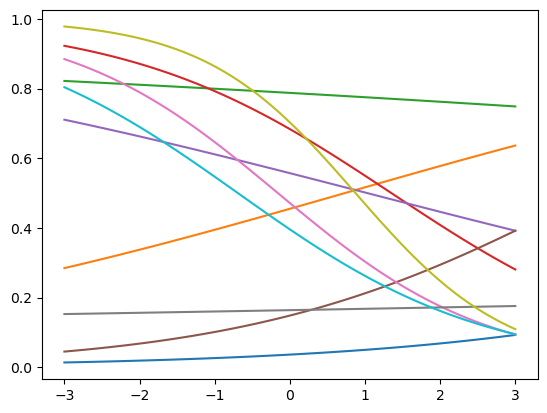

In [5]:
a = np.random.normal(0,1.5, size=1000)
b = np.random.normal(0,.5, size=1000)
xseq = np.linspace(-3,3,num=100)
plist = []

for x in xseq:
    p = expit(a+b*x)
    plist.append(p[:10])
plist = np.array(plist)

for i in range(10): 
    plt.plot(xseq,plist[:,i])
#Much more regularized, defensible 

In [6]:
with pm.Model() as total_sim:
    N = 1000 # Number of applicants
# Even Gender distribution 
    G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
    D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
    accept_rate = np.array([[0.05,0.1],[0.2,0.3]])# Direct discrimation
# Simulate acceptance
    Aobs = pm.MutableData('Aobs',np.random.binomial(1,accept_rate[D,G]))
    
    a = pm.Normal('a',0,1,shape=2)
    p =  pm.Deterministic("p", pm.math.invlogit(a[G]))
    A = pm.Bernoulli('A', p, observed = Aobs)
    
    tsim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [7]:
with pm.Model() as direct_sim:
    N = 1000 # Number of applicants
# Even Gender distribution 
    G = np.random.binomial(1, 0.5,size=N)
#Gender 1 tends to apply to department 1, 2 to 2
    D = np.random.binomial(1,[0.3 if x == 0 else 0.8 for x in G])
# Array of acceptance rates [dept,gender]
    accept_rate = np.array([[0.05,0.1],[0.2,0.3]])# Direct discrimation
# Simulate acceptance
    Aobs = pm.MutableData('Aobs',np.random.binomial(1,accept_rate[D,G]))
    
    #The model
    a = pm.Normal('a',0,1,shape=(2,2))
    p =  pm.Deterministic("p", pm.invlogit(a[G, D]))
    #A = pm.Bernoulli('A', p, observed = A)
    likelihood = pm.Bernoulli('A', p=p, observed=Aobs)
    dsim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [8]:
az.summary(tsim_trace)[:2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-2.099,0.145,-2.366,-1.829,0.002,0.002,4181.0,3017.0,1.0
a[1],-1.107,0.101,-1.301,-0.926,0.002,0.001,4205.0,2821.0,1.0


In [9]:
#Turning into the probability scale
expit(az.summary(dsim_trace)[:4]['mean'])

a[0, 0]    0.060882
a[0, 1]    0.159762
a[1, 0]    0.105836
a[1, 1]    0.295046
Name: mean, dtype: float64

In [10]:
##Actual Data

admin = pd.read_csv('./Data/UCBadmit.csv',sep=';')
admin.head()
#Note counts, turns it into a binomial 

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [11]:
admin['dept'].nunique()

6

In [12]:
admin['dept'].astype('category').cat.codes

1     0
2     0
3     1
4     1
5     2
6     2
7     3
8     3
9     4
10    4
11    5
12    5
dtype: int8

In [13]:
with pm.Model() as direct_model:
    G = admin['applicant.gender'].astype('category').cat.codes
    D = admin['dept'].astype('category').cat.codes
    N = admin['applications']
    a = pm.Normal('a',0,1,shape=(2,6)) #Shape is (genders,depts)
    p =  pm.Deterministic("p", pm.invlogit(a[G, D]))
    likelihood = pm.Binomial('A', N , p , observed=admin['admit'])
    direct_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [14]:
with pm.Model() as total_model:
    G = admin['applicant.gender'].astype('category').cat.codes
    D = admin['dept'].astype('category').cat.codes
    N = admin['applications']
    a = pm.Normal('a',0,1,shape=G.nunique()) #Shape is (genders,depts)
    p =  pm.Deterministic("p", pm.invlogit(a[G]))
    likelihood = pm.Binomial('A', N , p , observed=admin['admit'])
    total_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'p'}>,
        <AxesSubplot: title={'center': 'p'}>]], dtype=object)

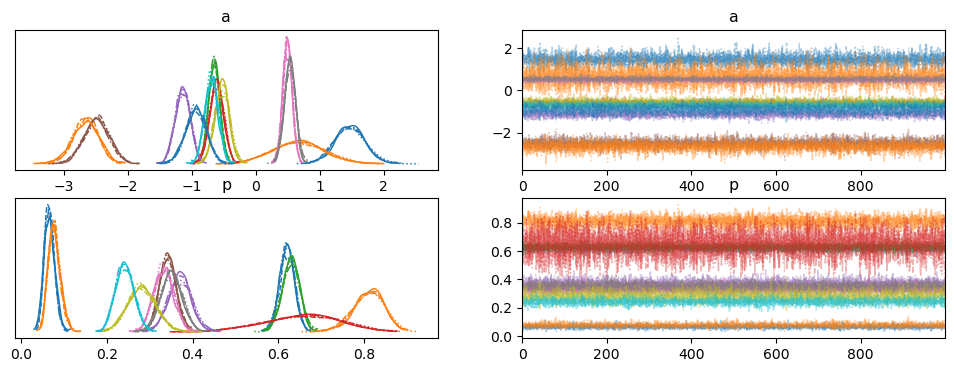

In [15]:
az.plot_trace(direct_trace)

In [16]:
az.summary(direct_trace)[:12]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",1.471,0.237,1.009,1.903,0.003,0.002,5670.0,2853.0,1.0
"a[0, 1]",0.664,0.400,-0.103,1.401,0.006,0.005,5220.0,3047.0,1.0
"a[0, 2]",-0.656,0.086,-0.811,-0.485,0.001,0.001,6637.0,2918.0,1.0
"a[0, 3]",-0.616,0.107,-0.817,-0.415,0.001,0.001,6723.0,3014.0,1.0
"a[0, 4]",-1.146,0.117,-1.371,-0.941,0.001,0.001,6840.0,2754.0,1.0
"a[0, 5]",-2.494,0.197,-2.876,-2.139,0.002,0.002,6867.0,3362.0,1.0
"a[1, 0]",0.492,0.074,0.355,0.635,0.001,0.001,6733.0,3251.0,1.0
"a[1, 1]",0.531,0.087,0.367,0.693,0.001,0.001,6923.0,2962.0,1.0
"a[1, 2]",-0.531,0.114,-0.742,-0.315,0.001,0.001,7186.0,3279.0,1.0
"a[1, 3]",-0.697,0.104,-0.891,-0.504,0.001,0.001,7128.0,3174.0,1.0


In [17]:
az.summary(total_trace)[:2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.829,0.051,-0.922,-0.733,0.001,0.001,4494.0,3134.0,1.0
a[1],-0.221,0.039,-0.291,-0.145,0.001,0.000,3793.0,3022.0,1.0


<AxesSubplot: >

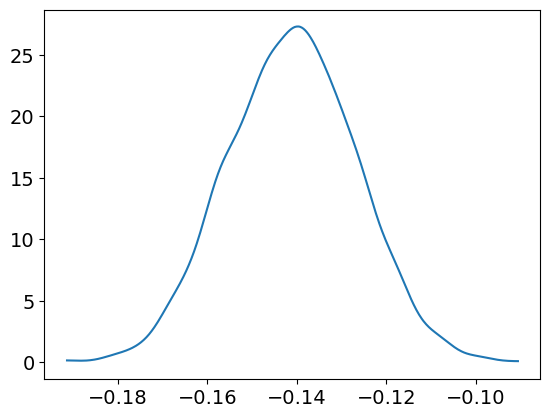

In [18]:
diff_prob = expit(total_trace.posterior.a[:,:,0].values) - expit(total_trace.posterior.a[:,:,1].values)
az.plot_kde(diff_prob)

#Men advantaged 

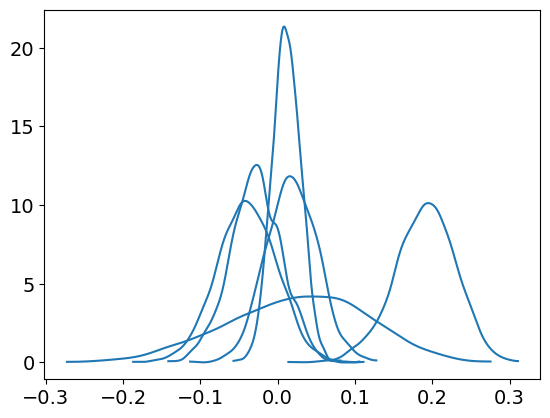

In [19]:
dexpit_a = expit(direct_trace.posterior.a)
diff_dept = dexpit_a[:,:,0,:].values - dexpit_a[:,:,1,:].values

for i in range(6):
    az.plot_kde(diff_dept[:,:,i])
#will figure out color later. 

What is the average direct effect of gender across departments?

Depends upon distribution of applications, probability woman/man applies to each department. 

What is the intervention actually?

To calculate causal effect of G, must average (marginalize) over departments

Easy to do it as a simulation

NB: We are still assuming no confounds!

In [20]:
admin.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_15924\2229801006.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  apps_per_dept = admin.groupby('dept').sum()['applications']
C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_15924\2229801006.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  a_diff = (direct_trace.posterior['a'][:,:,0]*apps_per_dept[np.newaxis, np.newaxis, :]) - (direct_trace.posterior['a'][:,:,1]*apps_per_dept[np.newaxis, np.newaxis, :])


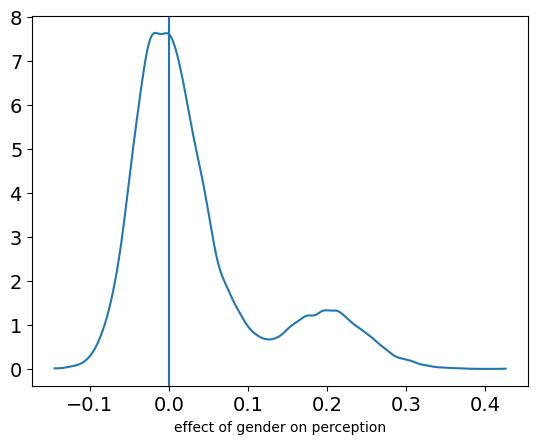

In [21]:
# Number of applications to simulate
total_apps = sum(admin['applications'])

#Number of applications per department 
apps_per_dept = admin.groupby('dept').sum()['applications']
#To simulate, we just take the posterior samples along the relevant
#dimensions and then multiply them by dept and divide by total apps
a_diff = (direct_trace.posterior['a'][:,:,0]*apps_per_dept[np.newaxis, np.newaxis, :]) - (direct_trace.posterior['a'][:,:,1]*apps_per_dept[np.newaxis, np.newaxis, :])
az.plot_kde(a_diff.values/total_apps)  
plt.xlabel('effect of gender on perception')
plt.axvline(0)

Marginalizing over emperical distributiosn of dept. Intervention is focused on perceptions (doesnt change rates of women and men applying). The counterfactual is switching the perceived gender. 

## Post-stratification

Description, prediction  causal inference often require post-stratification

**Post-stratification** : Re-weighting estimates for target population

At a different university, distribution of applications will differ => predicted consequence of intervention different.

Most scientific studies applied to human pop. need post-stratification, way of determining what a specific intervention will do. 

## Admissions so far

Evidence for discrimination? 

Big structural effects, but

1. Distribution of applications can be consequence of discrimination (data do not speak to this)

2. Confounds likely

## Survival Analysis

Counts often modeled as time-to-event

Tricky, because cannot ignore censored cases 

Left-censored: Don't know when time started

Right-censored: Observation ended before event

Ignoring censored cases leads to inferential error

Imagine estimating time-to-phd: Time in program before dropping out is info about rate

## Cat Adoptions

20-thousand cats

Estimand: Adoption rate of black and non-black cats

Events: 

1. Adopted

2. Something else

Something else could be: death, escape, **censored**

Outcome variable: days_to_event

What is a good distribution?

Basic choices: Exponential or gamma

**Exponential** : Simplest, constant rate through time, generative narrative is some machine/creature with many parts, if any part 'fails' then event happens. tracking days until event happens.  

**Gamma** : Multiple part failure, the 'machine' has redundancy. e.g. waiting time for cells to develop cancer (cos cells have many defensive parts). 

Maximum entropy distributions for waiting times

Generative story: X things required before event

## Uncensorsed observations

D~ Exponential(lambda)

p(D|lambda)=lambda*exp(-lambda*D)

1/lambda is the average waiting time. When lamba is 1, average waiting time is 1, when lambda is 0.5, average is 2 

## Censored Cats

Event Happened before or at x, Cumulative distribution (CDF)

Event didn't happen yet, Complementary cumulative distribution (CCDF)

Observed adoptions

Di|Ai = 1 ~ Exponential(lambdai)

Not-yet-adoptions

Di|Ai = 0 ~ Exponential-CCDF(lambdai)

lambdai = 1/mui

logmui = acidi (log average time to adoption)

In [22]:
cats = pd.read_csv('Data/AustinCats.csv',sep=';')
cats.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


In [23]:
cats.groupby('out_event').mean()

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_15924\1810621160.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cats.groupby('out_event').mean()


,days_to_event,intake_age
out_event,,
Adoption,38.401110,12.918157
Censored,37.389800,16.528233
Died,16.642276,14.872629
Disposal,26.888889,11.444444
Euthanasia,16.094340,40.779874
Missing,66.857143,8.892857
Transfer,9.369344,17.470788


In [24]:
cats[cats['color'] != 'Black'].groupby('out_event').days_to_event.mean()

out_event
Adoption      37.615486
Censored      38.317895
Died          17.018987
Disposal      32.857143
Euthanasia    16.848649
Missing       66.916667
Transfer       8.944869
Name: days_to_event, dtype: float64

In [25]:
cats[cats['color'] == 'Black'].groupby('out_event').days_to_event.mean()

out_event
Adoption      43.786851
Censored      31.432432
Died          14.396226
Disposal       6.000000
Euthanasia    10.925926
Missing       66.500000
Transfer      12.004594
Name: days_to_event, dtype: float64

In [26]:
coords = {'color':['black','other']}
with pm.Model(coords=coords) as cat_censored_m:
    days_to_event = np.array(cats['days_to_event'],dtype=float)
    adopted = np.array([1 if x == 'Adoption' else 0 for x in cats['out_event']])
    black = np.array([0 if x == 'Black' else 1 for x in cats['color']])
    
    a = pm.Normal('a', 1, 1,shape=2,dims='color')
    log_rate = 1/np.exp(a[black])

    upper_censoring = days_to_event.copy()
    upper_censoring[adopted==0] = np.inf  

    y_obs = pm.Censored(
        'y_obs', 
        pm.Exponential.dist(lam=log_rate),
        lower = None,
        upper=upper_censoring, 
        observed=days_to_event,
    )
   
    cat_censored_trace = pm.sample(initvals={'a':np.array([10,10])})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


In [27]:
az.summary(cat_censored_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[black],4.000,0.026,3.951,4.047,0.0,0.0,4498.0,3358.0,1.0
a[other],3.924,0.010,3.905,3.943,0.0,0.0,4268.0,2759.0,1.0


Text(0.5, 0, 'Waiting Time (Days)')

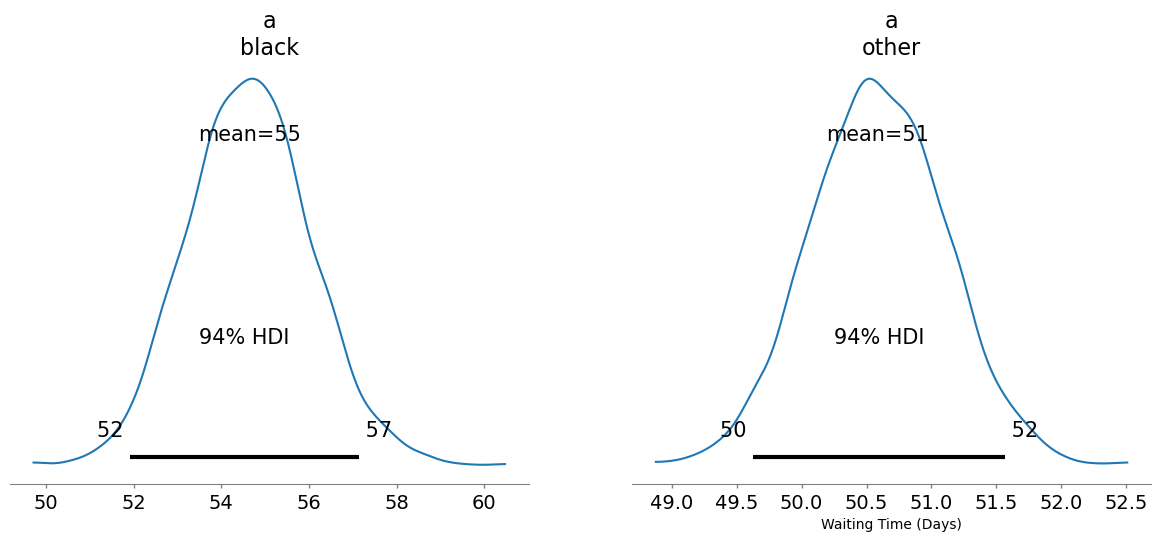

In [28]:
az.plot_posterior(cat_censored_trace,transform=np.exp)
plt.xlabel('Waiting Time (Days)')